In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text
import datetime as dt

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Finding my columns with the inspector
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

AttributeError: 'BarContainer' object has no attribute 'set_xticks'

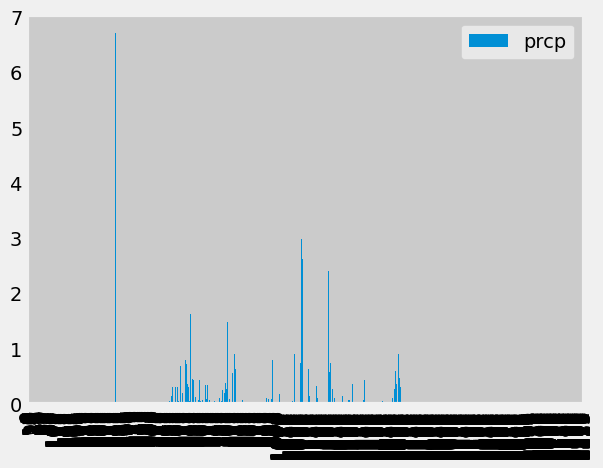

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

last_12_months = session.query(measurement.date, measurement.prcp)\
                .filter((measurement.date < '2017-08-23')&(measurement.date >=(dt.date(2017,8,23)-dt.timedelta(days=365)))).\
                order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(last_12_months)
# Sort the dataframe by date

sorted_df = df.sort_values(['date'])
sorted_df
# Use Pandas Plotting with Matplotlib to plot the data

chart = sorted_df.plot(kind='bar')
#x=np.arange(1,len(df['date'])+1) # I had a hard time
chart = plt.bar(x,df['prcp'])
chart.set_xticks([])
plt.title('One Year precipitation metrics in Inches')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = df.describe()
stats

,prcp
count,2017.000000
mean,0.177367
std,0.461568
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number of stations in the dataset
count = session.query(func.count(station.station)).all()
count

[(9,)]

In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station)\
            .order_by(func.count(measurement.station).desc()).all()

print(f'Station {stations[0]} has the greatest number of observations')
stations

Station ('USC00519281', 2772) has the greatest number of observations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs))\
        .filter(measurement.station=='USC00519281').all()
temps

[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

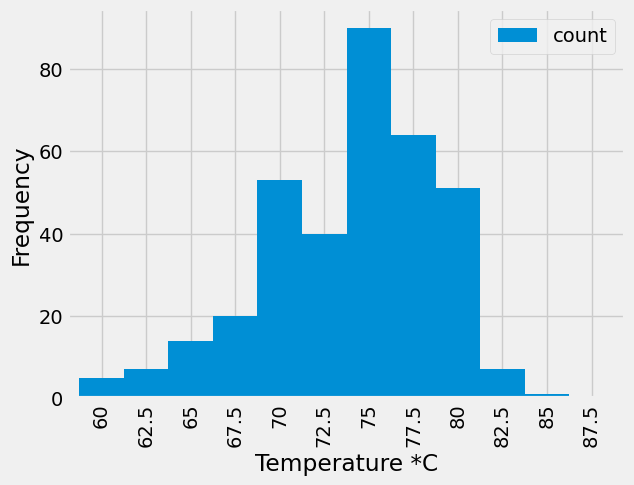

In [75]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# The below query was ran at first in order to query the last 12 months using session.query

last_12_months = session.query(measurement.tobs,func.count(measurement.tobs))\
                .filter((measurement.date < '2017-08-23')&(measurement.date >=(dt.date(2017,8,23)-dt.timedelta(days=365))))\
                .group_by(measurement.tobs).filter(measurement.station=='USC00519281').all()

#I continued the query using pandas.
#query = text('SELECT measurement.tobs, count(measurement.tobs) from measurement WHERE measurement.date<"2017-08-23" and measurement.date >="2016-08-23" and measurement.station = "USC00519281" GROUP BY measurement.tobs')
query = text('SELECT measurement.date, measurement.tobs from measurement WHERE measurement.date<"2017-08-23" and measurement.date >="2016-08-23" and measurement.station = "USC00519281"')
with engine.connect() as cxn:
    results = cxn.execute(query)
    df = pd.read_sql(query,cxn)

bins = [0,60,62.5,65,67.5,70,72.5,75,77.5,80,82.5,85,87.5]
labels =['60','62.5','65','67.5','70','72.5','75','77.5','80','82.5',"85","87.5"]
df['bins'] = pd.cut(df["tobs"],bins,labels=labels)

count = df['bins'].value_counts()

new_df = pd.DataFrame(count)
new_df = new_df.sort_index(axis=0)

new_df.plot(kind='bar', width =1)
plt.xlabel('Temperature *C')
plt.ylabel('Frequency')

In [18]:
# Close Session
session.close()